## Packages and Libraries

In [1]:
from __future__ import print_function
import numpy as np
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from classification_utilities import display_cm, display_adj_cm
from sklearn.metrics import confusion_matrix, f1_score, r2_score
from sklearn import preprocessing
from sklearn.model_selection import LeavePGroupsOut
from sklearn.multiclass import OneVsOneClassifier
from scipy.signal import medfilt
import data_augmentation as dtaug
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
import matplotlib.colors as colors
import plot_faceis as pltf

import xgboost as xgb
from xgboost.sklearn import  XGBClassifier
from hyperopt import STATUS_OK, fmin, hp, tpe
from sklearn.ensemble import RandomForestRegressor

## Input data

In [2]:
well0 = 'CHURCHMAN BIBLE'

#Load Data
input_data = pd.read_csv('facies_vectors.csv')

blind = input_data[input_data['Well Name'] == well0]
data = input_data[input_data['Well Name'] != well0]
input_data = input_data[input_data['Well Name'] != well0]

out1 = data[data['Well Name'] == 'ALEXANDER D']
data = data[data['Well Name'] != 'ALEXANDER D']

out2 = data[data['Well Name'] == 'KIMZEY A']
data = data[data['Well Name'] != 'KIMZEY A']

mean_PE=np.nanmean(input_data[input_data['Well Name'] == 'Recruit F9'].PE.values)
data=data.replace(np.nan,mean_PE)
input_data=input_data.replace(np.nan,mean_PE)

# Parameters
feature_names = ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'NM_M', 'RELPOS']
feature_names2 = ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS']

# Store features and labels
X = data[feature_names].values 
y = data['PE'].values 

# Store well labels and depths
well = data['Well Name'].values
depth = data['Depth'].values

#facies
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00', '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']
facies_names = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS', 'WS', 'D', 'PS', 'BS']

facies_color_map = {}
for ind, label in enumerate(facies_names):
    facies_color_map[label] = facies_colors[ind]

## Data augmentation

In [3]:
X_aug,feature_names_aug=dtaug.augment_regre(X, well, depth,feature_names)

data_aug=pd.DataFrame(X_aug,columns=feature_names_aug)
data_aug['Well Name'],data_aug['Depth'],data_aug['Facies'] = [well, depth,data['Facies'].values]

#X_train, X_test, y_train, y_test = train_test_split(X_aug, y, test_size=0.25, random_state=42)

In [4]:
logs = data_aug.copy()
logs['PE']=data['PE'].values

## CV for Random Forest

In [5]:
# configure the cross-validation procedure
cv_inner = KFold(n_splits=2, shuffle=True, random_state=1)
# define the model
est_reg = RandomForestRegressor(random_state=1,max_features='sqrt')
# define search space
param_grid = {'n_estimators':np.arange(80,101,2), 
'max_depth':np.arange(15,25,1)}

# define search
search = GridSearchCV(estimator=est_reg, param_grid=param_grid,
                      scoring='r2', n_jobs=-1, cv=cv_inner,
                       verbose=1, refit=True)

# configure the cross-validation procedure
groups = data['Well Name']
#cv_outer = LeaveOneGroupOut()

cv_outer = KFold(n_splits=7, shuffle=True, random_state=1)
# execute the nested cross-validation
scores = cross_val_score(search, X_aug, y, groups=groups, scoring='r2', cv=cv_outer, n_jobs=-1,verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:  3.4min finished


In [6]:
# report performance
print('Scores:',(scores),'\n')
print('R2: mean:%.3f (+/- %.3f)' % (np.mean(scores), np.std(scores)))

Scores: [0.8005699  0.78151147 0.79644391 0.81510202 0.82357644 0.82838525
 0.82179325] 

R2: mean:0.810 (+/- 0.016)


In [7]:
search.fit(X_aug,y)
best_parameters = search.best_params_
print(best_parameters)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 2 folds for each of 110 candidates, totalling 220 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done 220 out of 220 | elapsed:   34.5s finished


{'max_depth': 17, 'n_estimators': 100}


## Prediction

In [8]:
# Prepare training data
X_tr = X_aug
y_tr = y

# Prepare test data
well_ts = blind['Well Name'].values
depth_ts = blind['Depth'].values
X_ts = blind[feature_names].values

# Augment features
X_ts,_=dtaug.augment_regre(X_ts, well_ts, depth_ts,feature_names)

y_ts_hat=search.predict(X_ts)
blind['Predicted_PE'] = y_ts_hat 

score = r2_score (blind['PE'].values, blind['Predicted_PE'].values)
print("Score:%0.3f"%(score))

well_name_plot = 'NOLAN'

Score:0.721


In [10]:
# Prepare training data
X_tr = X_aug
y_tr = y

# Prepare test data
well_ts = blind['Well Name'].values
depth_ts = blind['Depth'].values
X_ts = blind[feature_names].values

# Augment features
X_ts,_=dtaug.augment_regre(X_ts, well_ts, depth_ts,feature_names)

y_ts_hat=search.predict(X_ts)
blind['Predicted_PE'] = y_ts_hat 

In [11]:
score = r2_score (blind['PE'].values, blind['Predicted_PE'].values)
print("Score {0}\n\n".format(score))

Score 0.7210490598006791




In [12]:
#well_name_plot = 'NOLAN' #well from train dataset 

#pltf.regression(data_aug,data,well_name_plot,clr_rfr,blind)

## Predict and attribute PE into missing wells

In [13]:
X_ts,_=dtaug.augment_regre(out1[feature_names].values, out1['Well Name'], \
                              out1['Depth'].values,feature_names)

input_data.loc[input_data.index[input_data['Well Name']=='ALEXANDER D'], \
               'PE'] = search.predict(X_ts)

X_ts,_=dtaug.augment_regre(out2[feature_names].values, out2['Well Name'], \
                              out2['Depth'].values,feature_names)

input_data.loc[input_data.index[input_data['Well Name'] =='KIMZEY A'], \
               'PE'] = search.predict(X_ts)

# Facies Classification

In [14]:
# Store features and labels
X = input_data[feature_names2].values 
y = input_data['Facies'].values 
well = input_data['Well Name'].values 
depth = input_data['Depth'].values 

### Augment features

In [15]:
X_aug, padded_rows = dtaug.augment_features(X, well, depth)

### Split the data in train and test

In [16]:
#from https://github.com/seg/2016-ml-contest/blob/master/LA_Team/Facies_classification_LA_TEAM_08.ipynb
# Initialize model selection methods
lpgo = LeavePGroupsOut(2)

# Generate splits
split_list = []
for train, val in lpgo.split(X, y, groups=input_data['Well Name']):
    hist_tr = np.histogram(y[train], bins=np.arange(len(facies_names)+1)+.5)
    hist_val = np.histogram(y[val], bins=np.arange(len(facies_names)+1)+.5)
    if np.all(hist_tr[0] != 0) & np.all(hist_val[0] != 0):
        split_list.append({'train':train, 'val':val})

def preprocess():
    
    # Preprocess data to use in model
    X_train_aux = []
    X_test_aux = []
    y_train_aux = []
    y_test_aux = []
    
    # For each data split
    for split in split_list:
        # Remove padded rows
        split_train_no_pad = np.setdiff1d(split['train'], padded_rows)

        # Select training and validation data from current split
        X_tr = X_aug[split_train_no_pad, :]
        X_v = X_aug[split['val'], :]
        y_tr = y[split_train_no_pad]
        y_v = y[split['val']]

        # Select well labels for validation data
        well_v = well[split['val']]

        X_train_aux.append( X_tr )
        X_test_aux.append( X_v )
        y_train_aux.append( y_tr )
        y_test_aux.append (  y_v )

        X_train = np.concatenate( X_train_aux )
        X_test = np.concatenate ( X_test_aux )
        y_train = np.concatenate ( y_train_aux )
        y_test = np.concatenate ( y_test_aux )
    
    return X_train , X_test , y_train , y_test 

X_train, X_test, y_train, y_test = preprocess()
y_train = y_train - 1 
y_test = y_test - 1 

## Cross Validation routine to define the hyperparameters

In [17]:
#modified from https://github.com/seg/2016-ml-contest/blob/master/LA_Team/Facies_classification_LA_TEAM_08.ipynb
SEED = 42

# Scoring and optimization functions

def score(params):
    print("Training with params: ")
    print(params)
    num_round = int(params['n_estimators'])
    del params['n_estimators']
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_test, label=y_test)
    watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
    gbm_model = xgb.train(params, dtrain, num_round,
                          evals=watchlist,
                          verbose_eval=True)
    y_predictions = gbm_model.predict(dvalid,
                                    ntree_limit=gbm_model.best_iteration + 1)
    
    score = f1_score (y_test, y_predictions , average ='micro')
    print("\tScore {0}\n\n".format(score))
    loss = 1 - score
    return {'loss': loss, 'status': STATUS_OK}


def optimize(random_state=SEED):
    space = {
        'n_estimators': hp.quniform('n_estimators', 100, 150, 1),
        'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
        'max_depth':  hp.choice('max_depth', np.arange(1, 14, dtype=int)),
        'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
        'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
        'eval_metric': 'mlogloss',
        'objective': 'multi:softmax',
        'booster': 'gbtree',
        'tree_method': 'exact',
        'silent': 1,
        'num_class' : 9,
        'seed': random_state
    }
    # Use the fmin function from Hyperopt to find the best hyperparameters
    best = fmin(score, space, algo=tpe.suggest,  max_evals=5)
    return best

In [18]:
#from https://github.com/seg/2016-ml-contest/blob/master/LA_Team/Facies_classification_LA_TEAM_08.ipynb
best_hyperparams = optimize()
print("The best hyperparameters are: ", "\n")
print(best_hyperparams)

Training with params:                                                                                                  
{'booster': 'gbtree', 'colsample_bytree': 0.55, 'eta': 0.05, 'eval_metric': 'mlogloss', 'gamma': 0.9, 'max_depth': 13, 'min_child_weight': 4.0, 'n_estimators': 146.0, 'num_class': 9, 'objective': 'multi:softmax', 'seed': 42, 'silent': 1, 'subsample': 0.6000000000000001, 'tree_method': 'exact'}
[15:54:49] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	eval-mlogloss:2.02369	train-mlogloss:2.02079                                                                       

[1]	eval-mlogloss:1.87075	train-mlogloss:1.86544              

[60]	eval-mlogloss:0.13011	train-mlogloss:0.12136                                                                      

[61]	eval-mlogloss:0.12562	train-mlogloss:0.11699                                                                      

[62]	eval-mlogloss:0.12139	train-mlogloss:0.11288                                                                      

[63]	eval-mlogloss:0.11732	train-mlogloss:0.10888                                                                      

[64]	eval-mlogloss:0.11352	train-mlogloss:0.10515                                                                      

[65]	eval-mlogloss:0.10979	train-mlogloss:0.10152                                                                      

[66]	eval-mlogloss:0.10634	train-mlogloss:0.09817                                                                      

[67]	eval-mlogloss:0.10303	train-mlogloss:0.09495                                                                      

[68]	eval-mlogloss:0.09970	train

[127]	eval-mlogloss:0.02864	train-mlogloss:0.02321                                                                     

[128]	eval-mlogloss:0.02828	train-mlogloss:0.02290                                                                     

[129]	eval-mlogloss:0.02794	train-mlogloss:0.02258                                                                     

[130]	eval-mlogloss:0.02764	train-mlogloss:0.02229                                                                     

[131]	eval-mlogloss:0.02738	train-mlogloss:0.02204                                                                     

[132]	eval-mlogloss:0.02712	train-mlogloss:0.02178                                                                     

[133]	eval-mlogloss:0.02685	train-mlogloss:0.02153                                                                     

[134]	eval-mlogloss:0.02659	train-mlogloss:0.02129                                                                     

[135]	eval-mlogloss:0.02633	trai

[40]	eval-mlogloss:1.19772	train-mlogloss:1.16058                                                                      

[41]	eval-mlogloss:1.18846	train-mlogloss:1.15126                                                                      

[42]	eval-mlogloss:1.17944	train-mlogloss:1.14222                                                                      

[43]	eval-mlogloss:1.17085	train-mlogloss:1.13351                                                                      

[44]	eval-mlogloss:1.16217	train-mlogloss:1.12482                                                                      

[45]	eval-mlogloss:1.15430	train-mlogloss:1.11671                                                                      

[46]	eval-mlogloss:1.14677	train-mlogloss:1.10893                                                                      

[47]	eval-mlogloss:1.13918	train-mlogloss:1.10128                                                                      

[48]	eval-mlogloss:1.13153	train

[107]	eval-mlogloss:0.88224	train-mlogloss:0.84604                                                                     

[108]	eval-mlogloss:0.87989	train-mlogloss:0.84368                                                                     

[109]	eval-mlogloss:0.87737	train-mlogloss:0.84134                                                                     

[110]	eval-mlogloss:0.87444	train-mlogloss:0.83857                                                                     

[111]	eval-mlogloss:0.87171	train-mlogloss:0.83605                                                                     

	Score 0.665809307333413                                                                                               


Training with params:                                                                                                  
{'booster': 'gbtree', 'colsample_bytree': 0.8500000000000001, 'eta': 0.1, 'eval_metric': 'mlogloss', 'gamma': 0.8500000000000001, 'max_depth': 12, 'min_c

[54]	eval-mlogloss:0.03078	train-mlogloss:0.02555                                                                      

[55]	eval-mlogloss:0.02973	train-mlogloss:0.02448                                                                      

[56]	eval-mlogloss:0.02871	train-mlogloss:0.02352                                                                      

[57]	eval-mlogloss:0.02789	train-mlogloss:0.02273                                                                      

[58]	eval-mlogloss:0.02702	train-mlogloss:0.02194                                                                      

[59]	eval-mlogloss:0.02626	train-mlogloss:0.02123                                                                      

[60]	eval-mlogloss:0.02557	train-mlogloss:0.02058                                                                      

[61]	eval-mlogloss:0.02496	train-mlogloss:0.02004                                                                      

[62]	eval-mlogloss:0.02428	train

[7]	eval-mlogloss:0.16984	train-mlogloss:0.16153                                                                       

[8]	eval-mlogloss:0.13741	train-mlogloss:0.12975                                                                       

[9]	eval-mlogloss:0.10966	train-mlogloss:0.10229                                                                       

[10]	eval-mlogloss:0.09048	train-mlogloss:0.08382                                                                      

[11]	eval-mlogloss:0.07497	train-mlogloss:0.06884                                                                      

[12]	eval-mlogloss:0.06322	train-mlogloss:0.05739                                                                      

[13]	eval-mlogloss:0.05323	train-mlogloss:0.04770                                                                      

[14]	eval-mlogloss:0.04560	train-mlogloss:0.04036                                                                      

[15]	eval-mlogloss:0.03860	train

[74]	eval-mlogloss:0.00914	train-mlogloss:0.00541                                                                      

[75]	eval-mlogloss:0.00910	train-mlogloss:0.00538                                                                      

[76]	eval-mlogloss:0.00910	train-mlogloss:0.00537                                                                      

[77]	eval-mlogloss:0.00910	train-mlogloss:0.00537                                                                      

[78]	eval-mlogloss:0.00907	train-mlogloss:0.00536                                                                      

[79]	eval-mlogloss:0.00907	train-mlogloss:0.00536                                                                      

[80]	eval-mlogloss:0.00907	train-mlogloss:0.00536                                                                      

[81]	eval-mlogloss:0.00907	train-mlogloss:0.00536                                                                      

[82]	eval-mlogloss:0.00903	train

[141]	eval-mlogloss:0.00874	train-mlogloss:0.00494                                                                     

[142]	eval-mlogloss:0.00874	train-mlogloss:0.00494                                                                     

[143]	eval-mlogloss:0.00874	train-mlogloss:0.00494                                                                     

[144]	eval-mlogloss:0.00874	train-mlogloss:0.00494                                                                     

[145]	eval-mlogloss:0.00865	train-mlogloss:0.00491                                                                     

[146]	eval-mlogloss:0.00865	train-mlogloss:0.00489                                                                     

[147]	eval-mlogloss:0.00865	train-mlogloss:0.00489                                                                     

[148]	eval-mlogloss:0.00865	train-mlogloss:0.00489                                                                     

	Score 0.998983131953583        

[51]	eval-mlogloss:0.01084	train-mlogloss:0.00797                                                                      

[52]	eval-mlogloss:0.01075	train-mlogloss:0.00788                                                                      

[53]	eval-mlogloss:0.01062	train-mlogloss:0.00781                                                                      

[54]	eval-mlogloss:0.01058	train-mlogloss:0.00775                                                                      

[55]	eval-mlogloss:0.01054	train-mlogloss:0.00772                                                                      

[56]	eval-mlogloss:0.01052	train-mlogloss:0.00770                                                                      

[57]	eval-mlogloss:0.01052	train-mlogloss:0.00770                                                                      

[58]	eval-mlogloss:0.01049	train-mlogloss:0.00765                                                                      

[59]	eval-mlogloss:0.01040	train

[118]	eval-mlogloss:0.00923	train-mlogloss:0.00643                                                                     

	Score 0.998983131953583                                                                                               


100%|███████████████████████████████████████████████| 5/5 [04:50<00:00, 58.11s/trial, best loss: 0.0010168680464169855]
The best hyperparameters are:  

{'colsample_bytree': 0.65, 'eta': 0.325, 'gamma': 0.6000000000000001, 'max_depth': 9, 'min_child_weight': 2.0, 'n_estimators': 149.0, 'subsample': 0.8500000000000001}


In [19]:
stop

NameError: name 'stop' is not defined

## Classifier

In [20]:
#modified from https://github.com/seg/2016-ml-contest/blob/master/LA_Team/Facies_classification_LA_TEAM_08.ipynb
# Train and test a classifier
def train_and_test(X_tr, y_tr, X_v, well_v):
    SEED = 42
    
    clf = XGBClassifier(colsample_bytree = 0.65, learning_rate=0.325, gamma = 0.6, max_depth=9, min_child_weight=2, n_estimators=149, seed = SEED, subsample = 0.85) 
    clf.fit(X_tr, y_tr)
    y_train_pred = clf.predict(X_tr)
    
    # Test classifier
    y_v_hat = clf.predict(X_v)
    
    # Clean isolated facies for each well
    for w in np.unique(well_v):
        y_v_hat[well_v==w] = medfilt(y_v_hat[well_v==w], kernel_size=5)
    
    return y_v_hat,y_train_pred

## Prediction

In [21]:
# Prepare training data
X_tr = X
y_tr = y

# Augment features
X_tr, padded_rows = dtaug.augment_features(X_tr, well, depth)

# Removed padded rows
X_tr = np.delete(X_tr, padded_rows, axis=0)
y_tr = np.delete(y_tr, padded_rows, axis=0) - 1

# Prepare test data
well_ts = blind['Well Name'].values
depth_ts = blind['Depth'].values
X_ts = blind[feature_names2].values

# Augment features
X_ts, padded_rows = dtaug.augment_features(X_ts, well_ts, depth_ts)

# Predict test labels
y_ts_hat,y_train_pred = train_and_test(X_tr, y_tr, X_ts, well_ts)

# Save predicted labels
blind['Predicted'] = y_ts_hat + 1

score_test = f1_score (y_tr, y_train_pred, average ='micro')
print("Score train {0} \n".format(score_test))

score = f1_score (blind['Facies'].values, blind['Predicted'].values, average ='micro')
print("Score blind {0} \n".format(score))

Score train0.9994636631804773 

Score blind0.5792079207920792 



In [22]:
confusion_matrix(blind['Facies'].values, blind['Predicted'].values)

array([[ 0,  8,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 30, 25,  1,  0,  0,  0,  0,  0],
       [ 0,  5, 38,  2,  4,  1,  0,  1,  0],
       [ 0,  0,  0, 10,  0,  3,  0,  0,  0],
       [ 0,  0,  1,  1,  8, 14,  0,  6,  0],
       [ 0,  0,  0, 11,  4, 59,  0, 10,  3],
       [ 0,  0,  1,  9,  5,  3,  2, 13,  1],
       [ 0,  0,  2,  0,  6, 25,  0, 41,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  4, 46]], dtype=int64)

In [23]:
from sklearn.metrics import classification_report

print(classification_report(blind['Facies'].values, blind['Predicted'].values))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         8
           2       0.70      0.54      0.61        56
           3       0.57      0.75      0.64        51
           4       0.29      0.77      0.43        13
           5       0.30      0.27      0.28        30
           6       0.56      0.68      0.61        87
           7       1.00      0.06      0.11        34
           8       0.55      0.55      0.55        75
           9       0.90      0.92      0.91        50

    accuracy                           0.58       404
   macro avg       0.54      0.50      0.46       404
weighted avg       0.62      0.58      0.56       404



C:\Users\felip\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Facies classification in blind well

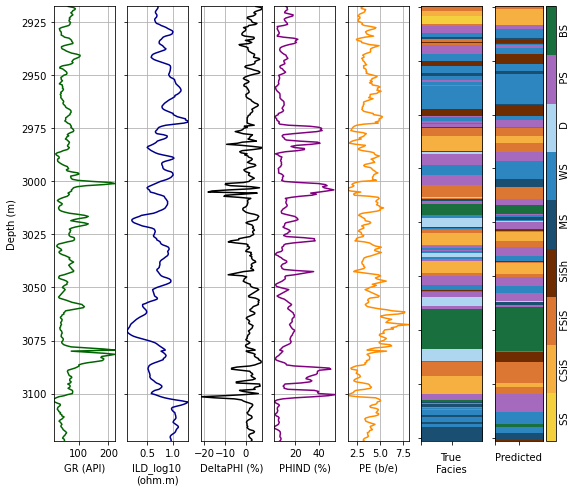

In [24]:
pltf.compare_facies_plot(blind, 'Predicted', facies_colors)